# Weather Station Data
## Level 1 QC

In [1]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import seaborn as sns; sns.set(style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1

In [2]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\WXmunge\\LVL1.py'>

** Define Location-Specific Baseline Settings **

In [3]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations; this depends on the naming convention of input data
timezone='America/Anchorage' #choose from pytz.all_timezones
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+"_990_ALL_15minLVL0.csv"

#time format and column
UTC_time_column_name='UTC_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL1/emily/" + Glacier.lower()+"_990_ALL_15minLVL1.csv"

### Data import
- read in data 
- set timezone
- set time as index

In [4]:
#read in level0 CSV
dat=pd.read_csv(pth)

#TIME SHOULD BE DEALT WITH IN LEVEL0 PROCESSING (aka before this); LEVEL 0 will have time in UTC.
#I'm doing it here because it is currently NOT; shift this block to level 0 processing when possible.
dat['time']=pd.to_datetime(dat[UTC_time_column_name], format= date_format) #this is not actually UTC time; it's UTC-8
dat['UTC']=dat.time + datetime.timedelta(hours=8) #This is now UTC time #THIS NAME MUST BE USED!

#Convert date to date-time object, and index of dataframe
dat['UTC']=pd.to_datetime(dat.UTC, format=date_format)
dat=dat.set_index("UTC") #Set this UTC time object as the index of the dataframe

#Timezone
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)
dat=dat.set_index('local_time')

#Create QC-Flag identical dataframe - will store QC status of each value
dat_qc_info = pd.DataFrame().reindex_like(dat)

Station-specific Data Adjustments

In [5]:
# Wolverine990: Prior to 2014.04.20, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=1 #seet QC flag to 1, indicating removed values
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=1

# Remove this subset after done troubleshooting!!

In [6]:
#Subset to 3 months, for speed during trouble-shoot
dat=dat['2015-03':'2015-06']

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [7]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.xlsx"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed:")
bad_sensor_dates_dat

Removed:


,Sensor,Start_Date,End_Date,Action,Correct_Label,Location
0,TAspirated2,2014-04-25 06:45:00,2014-09-04 09:00:00,switch_label,Tpassive2,Wolverine990
1,Tpassive1,2013-05-07 02:15:00,2013-11-06 08:00:00,bad,NaN,Wolverine990
2,Tpassive2,2013-11-06 08:00:00,2014-09-04 09:15:00,bad,NaN,Wolverine990
3,Tpassive2,2016-07-12 16:00:00,2016-08-18 03:59:00,bad,NaN,Wolverine990
4,TPGCumulative,2015-03-16 17:00:00,2015-03-19 00:00:00,bad,NaN,Wolverine990


** Set hard-coded cutoff values** (station specific)

In [8]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 #meters
    precip_drain_cutoff=-0.015
    obvious_error_precip_cutoff=0.3 #if 30 cm in 15 minutes, obviously an error.
    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' #time at which instrument was removed

** Clean Temperature Data**

In [9]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

#### Plot temperature data, before and after

** Plot original precipitation data**

<IPython.core.display.Javascript object>


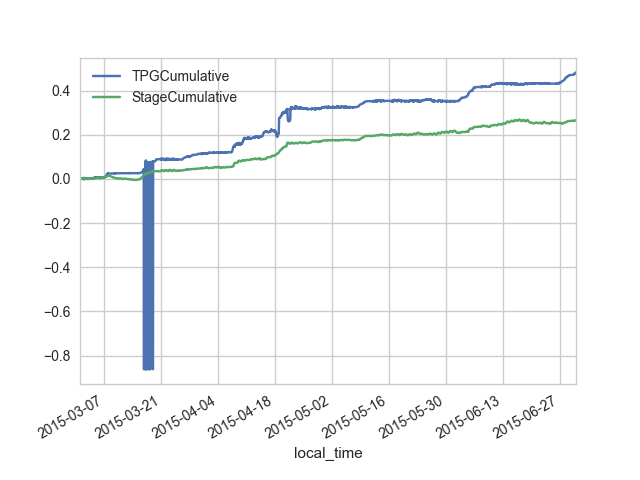

In [10]:
#Precip
precip_columns=['TPGCumulative', 'StageCumulative']
dat_original=dat.copy() #save unaltered data for later comparrison
for precip_col in precip_columns:
    dat_original.loc[:, precip_col]=dat_original[precip_col]-dat_original[precip_col][0] #adjust so that series begins at 0; neccesary for plots of non-full timeseries
dat_original[precip_columns].plot()

** Clean Precipitation Data **

In [11]:
#Set gages to NAN, when not installed (single gauge style does not cover period of record)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

In [12]:
#Remove short-duration sensor malfunctions with 6-sample hampel filter
for precip_col in precip_columns:
    dat.loc[:, precip_col]=LVL1.hampel(dat[precip_col], k=3)

<IPython.core.display.Javascript object>


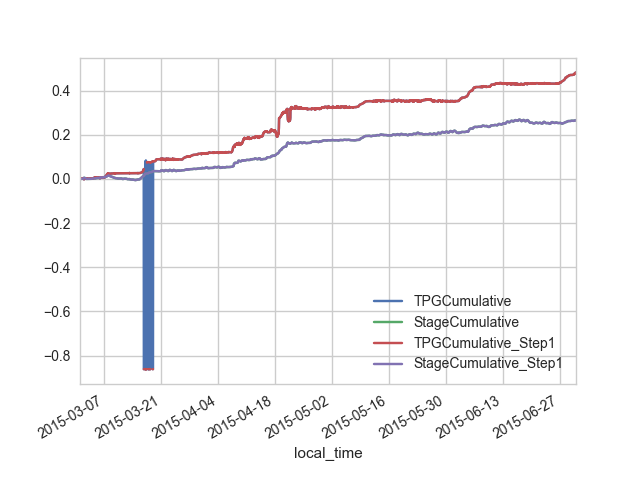

In [13]:
#Remove sensor malfunctions
for precip_col in precip_columns:
    dat.loc[:,precip_col]=LVL1.precip_remove_sensor_malfunctions(dat[precip_col], obvious_error_precip_cutoff)

#Save data for plotting
data_obv_errors_removed=dat.copy()
for precip_col in precip_columns:
    data_obv_errors_removed.loc[:, precip_col]=data_obv_errors_removed[precip_col]-data_obv_errors_removed[precip_col][0] #adjust so that series begins at 0; neccesary for plots of non-full timeseries

#Plot
data_obv_errors_removed=LVL1.rename_pandas_columns_for_plotting(data_obv_errors_removed, precip_columns, "_Step1") #save this data for later plotting
ax=dat_original[precip_columns].plot()
data_obv_errors_removed.plot(ax=ax)

<IPython.core.display.Javascript object>


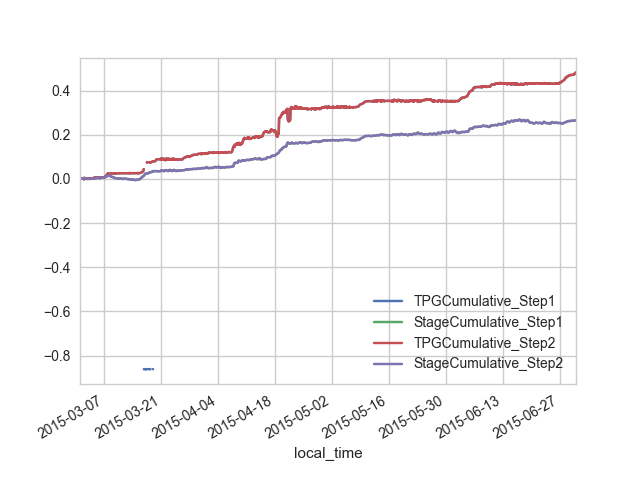

In [14]:
#Remove Instrument Malfunction Outliers
for precip_col in precip_columns:
    dat[precip_col]=LVL1.precip_remove_daily_outliers(dat[precip_col])

#Save data for plotting
step2=dat.copy()
for precip_col in precip_columns:
    step2.loc[:, precip_col]=step2[precip_col]-step2[precip_col][0] #adjust so that series begins at 0; neccesary for plots of non-full timeseries

#Plot
step2=LVL1.rename_pandas_columns_for_plotting(step2, precip_columns, "_Step2") #save this data for later plotting
ax=data_obv_errors_removed.plot()
step2.plot(ax=ax)

In [15]:
#Interpolate Gaps < 1 day in cumulative record
for precip_col in precip_columns:
    dat[precip_col]=LVL1.precip_interpolate_gaps_under1day(dat[precip_col])

In [16]:
#Remove noise from precip gage maintenance
for precip_col in precip_columns:
    dat[precip_col]=LVL1.precip_remove_maintenance_noise(dat[precip_col], obvious_error_precip_cutoff, precip_high_cutoff, precip_drain_cutoff)

<IPython.core.display.Javascript object>


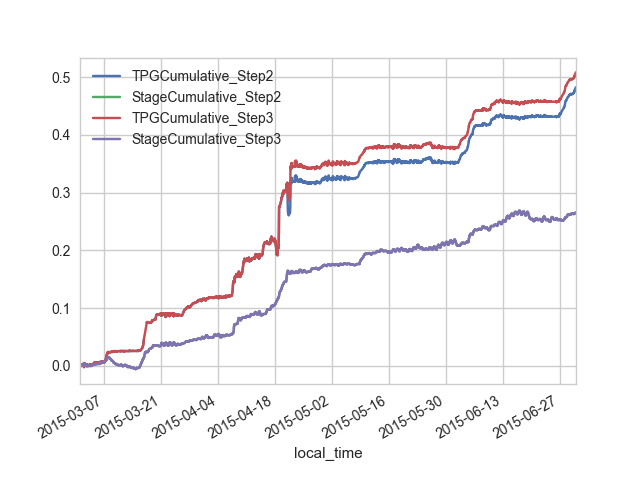

In [17]:
#Save data for plotting
step3=dat.copy()

#Plot
step3=LVL1.rename_pandas_columns_for_plotting(step3, precip_columns, "_Step3") #save this data for later plotting
ax=step2.plot()
step3.plot(ax=ax)

**Smooth Data with method from Nayak (2010): **

In [18]:
#Create columns of incremental precip
incremental_precip_columns=[] #initialize empty list that will hold column names of incremental precip; filled below
for precip_col in precip_columns:
    #Create an incremental timeseries for precip
    dPrecip=precip_col.split("Cumulative")[0]+ "Incremental" #create name for new incremental column
    incremental_precip_columns.append(dPrecip)
    dat[dPrecip]=dat[precip_col] - dat[precip_col].shift(1)

In [19]:
#Smooth Data
for incr_precip_col in incremental_precip_columns:
    #Smooth this data with method from Nayak 2010
    print ("smoothing "+ incr_precip_col)
    dat=LVL1.smooth_precip_Nayak2010(dat, incr_precip_col)

smoothing TPGIncremental
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute
smoothing StageIncremental
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute


** Plot Data After Smoothing **

<IPython.core.display.Javascript object>


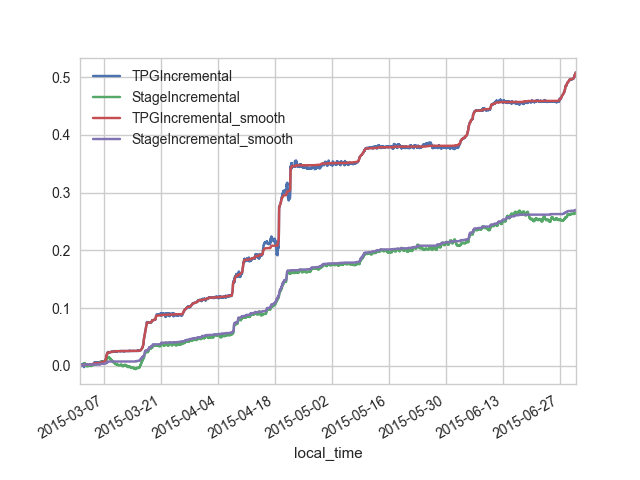

In [20]:
smoothed_columns=[s + "_smooth" for s in incremental_precip_columns] #names of columns post-smoothing
dat[incremental_precip_columns+smoothed_columns].cumsum().plot()

In [21]:
#Convert units from meters to mm
for col in smoothed_columns:
    dat.loc[:,col]=dat[col]*1000

In [22]:
#Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
for precip_col in smoothed_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

## Save Edited Data

In [23]:
#Time
dat['Local_time']=dat.index.tz_convert(local_timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
#Column Names
out_columns=['Local_time']+temp_columns+smoothed_columns+['RelHum', 'WindSpeed', 'WindGustSpeed', 'WindDir', 'LoggerTemp','LoggerBattery']
#Subset
save_dat=dat[out_columns] #removes unwanted columns
#Rename columns with "smooth" in them; match original naming
for col in smoothed_columns:
    newname=col.strip("_smooth")
    save_dat.rename(index=str, columns={col: newname}, inplace=True)

#Save
save_dat.to_csv(save_pth, index=False, float_format='%g')